In [1]:
from __future__ import print_function
from helpers import *
import numpy as np
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [23]:
IMG_CONTENT = '../img/content.png'
IMG_STYLE = '../img/style.png'
IMG_WIDTH = 360
IMG_HEIGHT = 360
IMG_CHANNEL = 3

img_content = scipy.misc.imread(IMG_CONTENT)
img_content = reshape_and_normalize_image(img_content, IMG_WIDTH, IMG_HEIGHT)
# 

img_style = scipy.misc.imread(IMG_STYLE)
img_style = reshape_and_normalize_image(img_style, IMG_WIDTH,IMG_HEIGHT)

img_generated = generate_noise_image(img_content, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)
# img_generated = (np.random.rand(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL) * 255).astype(int)


/Users/christian/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/christian/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [24]:
# noise_ratio = 0.6

# noise_image = np.random.uniform(0, 40, (1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)).astype('float32')
    
# img_generated = (noise_image * noise_ratio + img_content * (1 - noise_ratio)).astype(int)

# img_generated

# img_generated = (np.random.rand(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL) * 255).astype(int)

# plt.imshow(img_generated[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


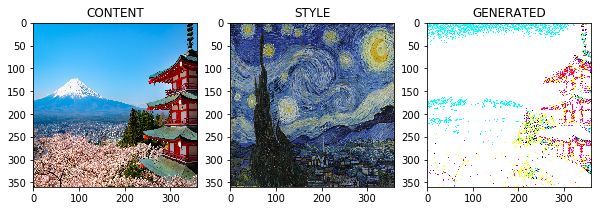

In [25]:
def show_images(img_content = img_content,
                img_style = img_style,
                img_generated = img_generated):
    fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(10,10))
    ax[0].imshow(img_content[0])
    ax[0].set_title("CONTENT")
    ax[1].imshow(img_style[0])
    ax[1].set_title("STYLE")
    ax[2].imshow(img_generated[0])
    ax[2].set_title("GENERATED")
    plt.show()
show_images()

In [5]:
def content_cost(con, gen):
    """
    Calculate the content cost of the generated picture.
    
    Parameters
    ----------
    con: 3d tensor
         The content tensor image.
    
    gen: 3d tensor
         The generated tensor image.
    """
    m, nw, nh, nc = gen.get_shape().as_list()
    con_flatten = tf.reshape(con, [-1])
    gen_flatten = tf.reshape(gen, [-1])
    J_content = tf.reduce_sum((con_flatten - gen_flatten)**2 / (4 * nw * nh * nc))
    return J_content


In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))


J_content = 6.76559


In [7]:
def gram_matrix(A):
    """
    Calculate the gram matrix of a given input.
    
    Parameters
    ----------
    A: tensor
       The tensor for calculating the gram matrix.
       
    Reference
    ---------
    https://en.wikipedia.org/wiki/Gramian_matrix
    """
    return tf.matmul(A, tf.transpose(A))

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [9]:
def style_cost(sty, gen):
    """
    Calculate the style cost of a single layer the generated picture.
    
    Parameters
    ----------
    sty: 3d tensor
         The style tensor image.
    
    gen: 3d tensor
         The generated tensor image.
    """
    m, nw, nh, nc = gen.get_shape().as_list()
    sty_res = tf.transpose(tf.reshape(sty, (nw * nh, nc)))
    gen_res = tf.transpose(tf.reshape(gen, (nw * nh, nc)))
    gm_sty = gram_matrix(sty_res)
    gm_gen = gram_matrix(gen_res)
    sty_flatten = tf.reshape(gm_sty, [-1])
    gen_flatten = tf.reshape(gm_gen, [-1])
    J_style = tf.reduce_sum((sty_flatten - gen_flatten)**2 / (4 * nc**2 * (nh * nw)**2))
    return J_style

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
STYLE_LAYERS = [
    ('conv1', 0.2),
    ('conv2', 0.2),
    ('conv3', 0.2),
    ('conv4', 0.2),
    ('conv5', 0.2)]

In [12]:
def full_style_cost(model, sess = tf.get_default_session(), STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    
    for layer_name, cost in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = style_cost(a_S, a_G)
        J_style += cost * J_style_layer
        
    return J_style

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Calculate the total cost of neural style transfer.
    
    Parameters
    ----------
    J_content: float
        The content cost.
    
    J_style: float
        The style cost.
    
    alpha: double
        Hyperparameter. J_content weight.
        
    beta: double
        Hyperparameter. J_style weight.
    """
    J = alpha * J_content + beta * J_style
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [15]:
# Hyperparameters
learning_rate = 0.001
num_classes = 1000
dropout_rate = 0.5
batch_size = 1

In [16]:
# tf.reset_default_graph()
# x = tf.placeholder(tf.float32, [batch_size, 360, 360, 3])
# x = tf.Variable(np.zeros((1, IMG_HEIGHT, IMG_WIDTH, 3)), dtype='float32')
# keep_prob = tf.placeholder(tf.float32)

In [26]:
tf.reset_default_graph()
model = export_graph(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)
sess = tf.InteractiveSession()
sess.run(model['input'].assign(img_content))
out = model['conv4']
a_C = sess.run(out)
a_G = out
J_content = content_cost(a_C, a_G)
print(type(a_G), type(a_C), type(J_content))

<class 'tensorflow.python.framework.ops.Tensor'> <class 'numpy.ndarray'> <class 'tensorflow.python.framework.ops.Tensor'>


In [27]:
sess.run(model['input'].assign(img_style))
J_style = full_style_cost(model, sess=sess)
J_style

<tf.Tensor 'add_4:0' shape=() dtype=float32>

In [28]:
J = total_cost(J_content, J_style)
J

<tf.Tensor 'add_5:0' shape=() dtype=float32>

In [29]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [47]:
def train(input_image, model = model, sess = tf.get_default_session(), num_iter=200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iter):
        _ = sess.run(train_step)
        generated_image = sess.run(model['input'])
        
        if i % 20 == 0:
            jt, jc, js = sess.run([J, J_content, J_style])
            print("Iteration: ", i)
            print("Total cost: ", str(jt))
            print("Content cost: ", str(jc))
            print("Style cost: ", str(js))
            
            save_image("output/" + str(i) + ".png", generated_image)
            
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [48]:
result = train(img_generated, model, sess, num_iter=800)

Iteration:  0
Total cost:  7.65936e+06
Content cost:  337.069
Style cost:  191400.0
Iteration:  20
Total cost:  1.73065e+06
Content cost:  512.597
Style cost:  43138.2
Iteration:  40
Total cost:  924391.0
Content cost:  575.89
Style cost:  22965.8
Iteration:  60
Total cost:  523145.0
Content cost:  610.784
Style cost:  12925.9
Iteration:  80
Total cost:  310129.0
Content cost:  631.259
Style cost:  7595.41
Iteration:  100
Total cost:  199149.0
Content cost:  644.555
Style cost:  4817.58
Iteration:  120
Total cost:  141158.0
Content cost:  654.803
Style cost:  3365.26
Iteration:  140
Total cost:  110179.0
Content cost:  662.132
Style cost:  2588.93
Iteration:  160
Total cost:  92328.5
Content cost:  669.092
Style cost:  2140.94
Iteration:  180
Total cost:  80837.4
Content cost:  675.802
Style cost:  1851.98
Iteration:  200
Total cost:  72751.4
Content cost:  680.716
Style cost:  1648.61
Iteration:  220
Total cost:  66689.0
Content cost:  684.553
Style cost:  1496.09
Iteration:  240
Tota

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


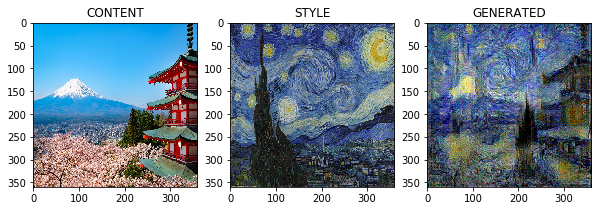

In [46]:
show_images(img_generated = result.astype(int))